## Introduction
This notebook is an exploration of the Food.com dataset that focuses primarily on looking at variables that are specific to particular ingredients, such as the frequency with which they are included in recipes in the dataset, and their usage in submitted recipes over time. This notebook also creates a model for predicting probabilities that a given recipe includes a particular ingredient, given the name chosen for that recipe.

   
## Table of Contents
- [Reading in and merging the data](#1)
- [Looking at data related to ingredients](#2)
    - [Ingredient frequency](#2.1)
    - [Ingredient-specific review scores](#2.2)
    - [Ingredient usage over time](#2.3)
- [Naive Bayes Model](#3)
    - [Getting recipe name tokens](#3.1)
    - [Estimating probabilities](#3.2)
    - [Trying out the model](#3.3)

In [1]:
from collections import defaultdict
from plotnine import *
import plotnine
import numpy as np
import pandas as pd
import ast
import os
import math
import warnings
warnings.filterwarnings('ignore')

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/food-com-recipes-and-user-interactions/RAW_interactions.csv
/kaggle/input/food-com-recipes-and-user-interactions/ingr_map.pkl
/kaggle/input/food-com-recipes-and-user-interactions/PP_recipes.csv
/kaggle/input/food-com-recipes-and-user-interactions/RAW_recipes.csv
/kaggle/input/food-com-recipes-and-user-interactions/interactions_train.csv
/kaggle/input/food-com-recipes-and-user-interactions/interactions_test.csv
/kaggle/input/food-com-recipes-and-user-interactions/PP_users.csv
/kaggle/input/food-com-recipes-and-user-interactions/interactions_validation.csv


## Reading in and merging the data <a name="1"></a>
Read in the files from the dataset that we want to look at.

In [2]:
raw_recipes = pd.read_csv("/kaggle/input/food-com-recipes-and-user-interactions/RAW_recipes.csv")
raw_interactions = pd.read_csv("/kaggle/input/food-com-recipes-and-user-interactions/RAW_interactions.csv")
pp_recipes = pd.read_csv("/kaggle/input/food-com-recipes-and-user-interactions/PP_recipes.csv")
pp_users = pd.read_csv("/kaggle/input/food-com-recipes-and-user-interactions/PP_users.csv")
ingr_map = pd.read_pickle("/kaggle/input/food-com-recipes-and-user-interactions/ingr_map.pkl")

Let's create a merged version of the recipes data (where rows refer to a unique recipe) that has both the raw and preprocessed data, and just the columns we care about. Let's also rename the ID column to specifically state that it is referring to a recipe ID, which will be useful when merging data between dataframes.

In [3]:
recipes = pp_recipes.merge(right=raw_recipes, left_on="id", right_on="id")
recipes = recipes[["id", "name", "submitted", "ingredient_ids", "ingredients", "n_ingredients"]]
recipes = recipes.rename({"id":"recipe_id"}, axis="columns")
recipes.head()

,recipe_id,name,submitted,ingredient_ids,ingredients,n_ingredients
0,424415,aromatic basmati rice rice cooker,2010-05-10,"[389, 7655, 6270, 1527, 3406]","['basmati rice', 'water', 'salt', 'cinnamon st...",5
1,146223,pumpkin pie a la easy,2005-11-25,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,...","['flour', 'oats', 'brown sugar', 'pecans', 'bu...",12
2,312329,cheesy tomato soup with potatoes,2008-07-07,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696...","['chicken broth', 'water', 'salt', 'black pepp...",15
3,74301,mini tacos,2003-10-29,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]","['wonton wrappers', 'hamburger', 'taco seasoni...",8
4,76272,rosemary s hanky panky s,2003-11-12,"[3484, 6324, 7594, 243]","['ground beef', 'ground sausage', 'velveeta ch...",4


That look's good, let's move on the interactions data.

In [4]:
interactions = raw_interactions[["user_id", "recipe_id", "rating", "review"]]
interactions.head()

,user_id,recipe_id,rating,review
0,38094,40893,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,4,This worked very well and is EASY. I used not...
3,126440,85009,5,I made the Mexican topping and took it to bunk...
4,57222,85009,5,"Made the cheddar bacon topping, adding a sprin..."


That looks good too, let's move on to the ingredients. For the ingredients dataframe, let's again rename the columns to make a clear distinction between ID types before merging any data. The original file has raw strings from which the ingredients were parsed out and preprocessed. Let's just look at the preprocessed strings and get rid of duplicate rows, so that a single row in this dataframe now refers to a unique ingredient in the dataset. That way we can add on to this dataframe with new variables that have values specific to a particular ingredient, like its frequency in the dataset, or the average review score for recipes that include it.

In [5]:
ingr_df = ingr_map.copy(deep=True)
ingr_df = ingr_df.rename({"id":"ingr_id","replaced":"ingr_name"}, axis="columns")
ingr_df = ingr_df[["ingr_id", "ingr_name"]]
ingr_df = ingr_df.drop_duplicates(ignore_index=True)
ingr_df.head(10)

,ingr_id,ingr_name
0,4308,lettuce
1,2744,french vanilla pudding and pie filling mix
2,6843,stove top stuffing mix
3,1910,cream cheese
4,1168,cheddar
5,5811,radicchio
6,5205,pasta sauce
7,7233,tomato sauce
8,6482,shredded three cheese
9,4836,mozzarella


## Looking at data related to ingredients <a name="2"></a>
### Looking at the frequency of specific ingredients <a name="2.1"></a>

In order to define other variables with respect to particular ingredients, let's create a version of the recipes dataframe that is exploded with respect to the column that has the list of ingredient IDs. This will form a dataframe where each row refers to a specific ingredient present in a specific recipe. Note that in order to do this, we need to convert the contents of the ingredient IDs field to be actual lists rather than strings representing lists. 

In [6]:
recipes_exploded = recipes.copy(deep=True)
recipes_exploded["ingredient_ids"] = recipes_exploded['ingredient_ids'].apply(lambda x : ast.literal_eval(x))
recipes_exploded = recipes_exploded.explode(column="ingredient_ids", ignore_index=True)
recipes_exploded.head(10)

,recipe_id,name,submitted,ingredient_ids,ingredients,n_ingredients
0,424415,aromatic basmati rice rice cooker,2010-05-10,389,"['basmati rice', 'water', 'salt', 'cinnamon st...",5
1,424415,aromatic basmati rice rice cooker,2010-05-10,7655,"['basmati rice', 'water', 'salt', 'cinnamon st...",5
2,424415,aromatic basmati rice rice cooker,2010-05-10,6270,"['basmati rice', 'water', 'salt', 'cinnamon st...",5
3,424415,aromatic basmati rice rice cooker,2010-05-10,1527,"['basmati rice', 'water', 'salt', 'cinnamon st...",5
4,424415,aromatic basmati rice rice cooker,2010-05-10,3406,"['basmati rice', 'water', 'salt', 'cinnamon st...",5
5,146223,pumpkin pie a la easy,2005-11-25,2683,"['flour', 'oats', 'brown sugar', 'pecans', 'bu...",12
6,146223,pumpkin pie a la easy,2005-11-25,4969,"['flour', 'oats', 'brown sugar', 'pecans', 'bu...",12
7,146223,pumpkin pie a la easy,2005-11-25,800,"['flour', 'oats', 'brown sugar', 'pecans', 'bu...",12
8,146223,pumpkin pie a la easy,2005-11-25,5298,"['flour', 'oats', 'brown sugar', 'pecans', 'bu...",12
9,146223,pumpkin pie a la easy,2005-11-25,840,"['flour', 'oats', 'brown sugar', 'pecans', 'bu...",12


Because ingredient IDs are now in their own column, we can now group by ingredient and check the quantity of recipes that each belongs to, and add this to the ingredients dataframe.

In [7]:
ingr_df["num_recipes"] = ingr_df["ingr_id"].map(dict(recipes_exploded.groupby("ingredient_ids")["recipe_id"].size()))
ingr_df.head(10)

,ingr_id,ingr_name,num_recipes
0,4308,lettuce,4294.0
1,2744,french vanilla pudding and pie filling mix,4.0
2,6843,stove top stuffing mix,106.0
3,1910,cream cheese,8966.0
4,1168,cheddar,12300.0
5,5811,radicchio,83.0
6,5205,pasta sauce,412.0
7,7233,tomato sauce,3637.0
8,6482,shredded three cheese,NaN
9,4836,mozzarella,4878.0


Let's get the total number of recipes in the dataset so that these counts can be represented as frequencies.

In [8]:
total_number_of_recipes = recipes["recipe_id"].unique().size
ingr_df["frequency"] = ingr_df["num_recipes"]/total_number_of_recipes
ingr_df.head(10)

,ingr_id,ingr_name,num_recipes,frequency
0,4308,lettuce,4294.0,0.024088
1,2744,french vanilla pudding and pie filling mix,4.0,0.000022
2,6843,stove top stuffing mix,106.0,0.000595
3,1910,cream cheese,8966.0,0.050296
4,1168,cheddar,12300.0,0.068998
5,5811,radicchio,83.0,0.000466
6,5205,pasta sauce,412.0,0.002311
7,7233,tomato sauce,3637.0,0.020402
8,6482,shredded three cheese,NaN,NaN
9,4836,mozzarella,4878.0,0.027364


Some of the ingredients in this dataframe are not actually used in any of the recipes that are included in the dataset, so let's get rid of those.

In [9]:
ingr_df = ingr_df.dropna()
ingr_df.head(10)

,ingr_id,ingr_name,num_recipes,frequency
0,4308,lettuce,4294.0,0.024088
1,2744,french vanilla pudding and pie filling mix,4.0,0.000022
2,6843,stove top stuffing mix,106.0,0.000595
3,1910,cream cheese,8966.0,0.050296
4,1168,cheddar,12300.0,0.068998
5,5811,radicchio,83.0,0.000466
6,5205,pasta sauce,412.0,0.002311
7,7233,tomato sauce,3637.0,0.020402
9,4836,mozzarella,4878.0,0.027364
10,912,cake mix,2344.0,0.013149


### Getting scores specific to individual ingredients <a name="2.2"></a>

We also might want to know if there is a relationship between particular ingredients and review scores. Scores are attributed to recipes not ingredients, so we need to merge the ingredient lists from the recipes dataframe with the interactions dataframe, so that we can then explode that dataframe with respect to the ingredients list.

In [10]:
interactions_exploded = interactions.copy(deep=True)
interactions_exploded = interactions_exploded.merge(how="left", right=recipes[["recipe_id","ingredient_ids"]], left_on="recipe_id", right_on="recipe_id")
interactions_exploded = interactions_exploded.dropna()
interactions_exploded["ingredient_ids"] = interactions_exploded['ingredient_ids'].apply(lambda x : ast.literal_eval(x))
interactions_exploded = interactions_exploded.explode(column="ingredient_ids", ignore_index=True)
interactions_exploded.head(10)

,user_id,recipe_id,rating,review,ingredient_ids
0,38094,40893,4,Great with a salad. Cooked on top of stove for...,3384
1,38094,40893,4,Great with a salad. Cooked on top of stove for...,7979
2,38094,40893,4,Great with a salad. Cooked on top of stove for...,2127
3,38094,40893,4,Great with a salad. Cooked on top of stove for...,3502
4,38094,40893,4,Great with a salad. Cooked on top of stove for...,3217
5,38094,40893,4,Great with a salad. Cooked on top of stove for...,1257
6,38094,40893,4,Great with a salad. Cooked on top of stove for...,2778
7,38094,40893,4,Great with a salad. Cooked on top of stove for...,5006
8,38094,40893,4,Great with a salad. Cooked on top of stove for...,6654
9,1293707,40893,5,"So simple, so delicious! Great for chilly fall...",3384


We can use those relationships to add mean rating for each recipe that includes a given ingredient and the total number of reviews that were created for all recipes including a given ingredient to the ingredients dataframe.

In [11]:
ingr_df["mean_rating"] = ingr_df["ingr_id"].map(dict(interactions_exploded.groupby("ingredient_ids")["rating"].mean()))
ingr_df["num_ratings"] = ingr_df["ingr_id"].map(dict(interactions_exploded.groupby("ingredient_ids")["rating"].size()))
ingr_df.head(10)

,ingr_id,ingr_name,num_recipes,frequency,mean_rating,num_ratings
0,4308,lettuce,4294.0,0.024088,4.553558,17859
1,2744,french vanilla pudding and pie filling mix,4.0,0.000022,4.400000,5
2,6843,stove top stuffing mix,106.0,0.000595,4.261090,789
3,1910,cream cheese,8966.0,0.050296,4.470405,50937
4,1168,cheddar,12300.0,0.068998,4.434023,72851
5,5811,radicchio,83.0,0.000466,4.567010,194
6,5205,pasta sauce,412.0,0.002311,4.461032,1976
7,7233,tomato sauce,3637.0,0.020402,4.416130,23918
9,4836,mozzarella,4878.0,0.027364,4.489368,25960
10,912,cake mix,2344.0,0.013149,4.458136,13317


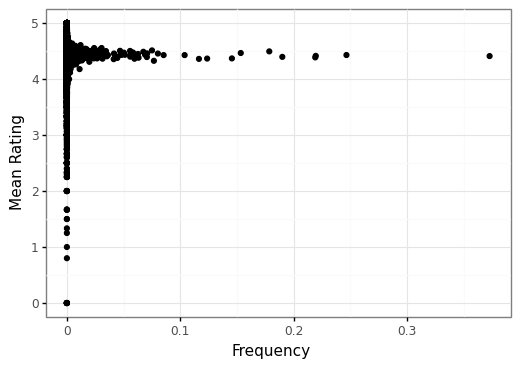

<ggplot: (8793368333673)>

In [12]:
plotnine.options.dpi = 100
plotnine.options.figure_size=(6,4)
(ggplot(ingr_df)
 + geom_point(aes(x="frequency", y="mean_rating"), color="black", show_legend=False)
 + theme_bw()
 + ylab("Mean Rating")
 + xlab("Frequency")
)

For ingredients that are used more frequently, the mean rating for all recipes that they are in tends to be closer and closer to the mean for all recipe ratings in the dataset, as expected. The inclusion of less frequently does not necessarily seem to impact the average review score for recipes that include it. As another way to visualize this, let's consider that 'rare' ingredients are ones mentioned 5 or fewer times in the dataset, then bin recipes based on how many 'rare' ingredients they include, then look at the average score distributions for all recipes in each bin.

In [13]:
threshold = 5
rare_ingredients = ingr_df.loc[ingr_df["num_recipes"] <= threshold, "ingr_id"].values
recipes_exploded["rare_ingr"] = recipes_exploded["ingredient_ids"].map(lambda x: x in rare_ingredients)
recipes_exploded.head(10)

,recipe_id,name,submitted,ingredient_ids,ingredients,n_ingredients,rare_ingr
0,424415,aromatic basmati rice rice cooker,2010-05-10,389,"['basmati rice', 'water', 'salt', 'cinnamon st...",5,False
1,424415,aromatic basmati rice rice cooker,2010-05-10,7655,"['basmati rice', 'water', 'salt', 'cinnamon st...",5,False
2,424415,aromatic basmati rice rice cooker,2010-05-10,6270,"['basmati rice', 'water', 'salt', 'cinnamon st...",5,False
3,424415,aromatic basmati rice rice cooker,2010-05-10,1527,"['basmati rice', 'water', 'salt', 'cinnamon st...",5,False
4,424415,aromatic basmati rice rice cooker,2010-05-10,3406,"['basmati rice', 'water', 'salt', 'cinnamon st...",5,False
5,146223,pumpkin pie a la easy,2005-11-25,2683,"['flour', 'oats', 'brown sugar', 'pecans', 'bu...",12,False
6,146223,pumpkin pie a la easy,2005-11-25,4969,"['flour', 'oats', 'brown sugar', 'pecans', 'bu...",12,False
7,146223,pumpkin pie a la easy,2005-11-25,800,"['flour', 'oats', 'brown sugar', 'pecans', 'bu...",12,False
8,146223,pumpkin pie a la easy,2005-11-25,5298,"['flour', 'oats', 'brown sugar', 'pecans', 'bu...",12,False
9,146223,pumpkin pie a la easy,2005-11-25,840,"['flour', 'oats', 'brown sugar', 'pecans', 'bu...",12,False


In [14]:
recipes["num_rare_ingr"] = recipes["recipe_id"].map(dict(recipes_exploded.groupby("recipe_id")["rare_ingr"].sum()))
recipes.head(10)

,recipe_id,name,submitted,ingredient_ids,ingredients,n_ingredients,num_rare_ingr
0,424415,aromatic basmati rice rice cooker,2010-05-10,"[389, 7655, 6270, 1527, 3406]","['basmati rice', 'water', 'salt', 'cinnamon st...",5,0
1,146223,pumpkin pie a la easy,2005-11-25,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,...","['flour', 'oats', 'brown sugar', 'pecans', 'bu...",12,0
2,312329,cheesy tomato soup with potatoes,2008-07-07,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696...","['chicken broth', 'water', 'salt', 'black pepp...",15,0
3,74301,mini tacos,2003-10-29,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]","['wonton wrappers', 'hamburger', 'taco seasoni...",8,0
4,76272,rosemary s hanky panky s,2003-11-12,"[3484, 6324, 7594, 243]","['ground beef', 'ground sausage', 'velveeta ch...",4,0
5,465171,pink bavarian crown strawberry dream supreme,2011-09-29,"[6861, 7655, 6846, 6906, 1789, 131, 6863, 1833...","['strawberry jell-o gelatin dessert', 'water',...",10,0
6,163861,tom and kelly s chicken fried steak,2006-04-11,"[5574, 2683, 6270, 5319, 2499, 869, 1278, 4987...","['boneless pork chops', 'flour', 'salt', 'pepp...",9,0
7,186383,chocolate oat cookie bars,2006-09-15,"[2683, 4969, 332, 335, 6270, 800, 4987, 7470, ...","['flour', 'oats', 'baking powder', 'baking sod...",10,0
8,116395,tropical lemon cream bars,2005-04-12,"[2683, 1689, 5687, 1098, 840, 7782, 7011, 1910...","['flour', ""confectioners' sugar"", 'powdered mi...",13,0
9,303460,jeera on cubes barbecue marinade,2008-05-13,"[6413, 7997, 3148, 3710, 1799, 2007, 3203, 265...","['sesame oil', 'yoghurt', 'fruit vinegar', 'ho...",9,1


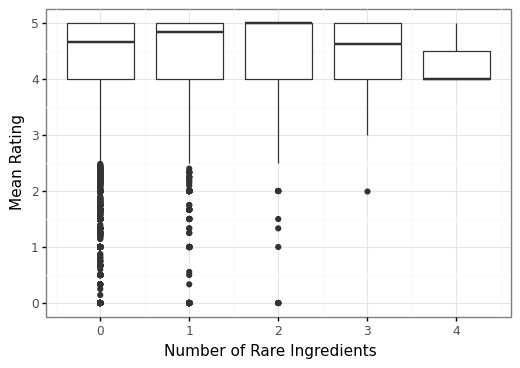

<ggplot: (8793368326061)>

In [15]:
recipes["mean_rating"] = recipes["recipe_id"].map(dict(interactions.groupby("recipe_id")["rating"].mean()))

plotnine.options.dpi = 100
plotnine.options.figure_size=(6,4)
(ggplot(recipes)
 + geom_boxplot(aes(x="num_rare_ingr", y="mean_rating", group="num_rare_ingr"), show_legend=False)
 + theme_bw()
 + ylab("Mean Rating")
 + xlab("Number of Rare Ingredients")
)

We should also look at the number of recipes in each category (in each boxplot).

In [16]:
recipes.groupby("num_rare_ingr").size()

num_rare_ingr
0    170243
1      7632
2       359
3        28
4         3
dtype: int64

### Looking at ingredient inclusion over time <a name="2.3"></a>
Another aspect of this dataset at the ingredient level is how the inclusion of specific ingredients in submitted recipes changes over time. These trends might have something to do with changing popularity of specific foods or recipes, or prices or availability of particular ingredients. Drawing conclusions would require in depth knowledge of the submitted recipes were sampled from all recipes submitted during these periods, and when the recipes are accessed is also relevant rather than just when the recipes were submitted, but this section provides a simple example of getting started with this type of analysis.

Let's get started by making a histogram of recipes based no the year they were submitted.

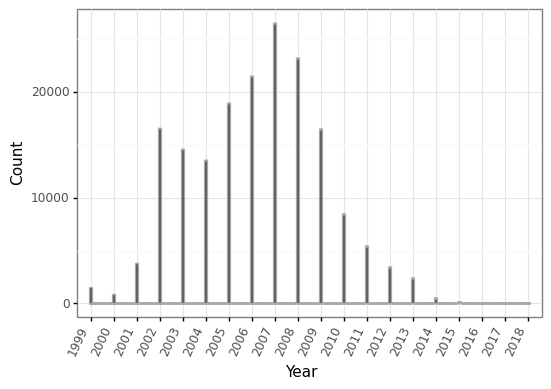

<ggplot: (8793369078489)>

In [17]:
recipes["submitted"]
recipes["year"] = recipes["submitted"].map(lambda x: x.split("-")[0])
recipes = recipes.sort_values(by="year")

plotnine.options.dpi = 100
plotnine.options.figure_size=(6,4)
(ggplot(recipes)
 + geom_histogram(aes(x="year"), color="darkgray", show_legend=False)
 + theme_bw()
 + ylab("Count")
 + xlab("Year")
 + theme(axis_text_x=element_text(rotation=65, hjust=1))
)

The most well-represented portion of the data is from 2002 to 2009, so lets limit the dataset to those years when looking at trends in ingredient usage.

In [18]:
recipes_subset = recipes_exploded.copy(deep=True)
recipes_subset["year"] = recipes_subset["submitted"].map(lambda x: x.split("-")[0]).astype(int)
recipes_subset["year"] = recipes_subset["year"].astype(int)
recipes_subset = recipes_subset[(recipes_subset["year"]>=2002) & (recipes_subset["year"]<=2009)]
recipes_subset.reset_index(inplace=True)
recipes_subset.head()

,index,recipe_id,name,submitted,ingredient_ids,ingredients,n_ingredients,rare_ingr,year
0,5,146223,pumpkin pie a la easy,2005-11-25,2683,"['flour', 'oats', 'brown sugar', 'pecans', 'bu...",12,False,2005
1,6,146223,pumpkin pie a la easy,2005-11-25,4969,"['flour', 'oats', 'brown sugar', 'pecans', 'bu...",12,False,2005
2,7,146223,pumpkin pie a la easy,2005-11-25,800,"['flour', 'oats', 'brown sugar', 'pecans', 'bu...",12,False,2005
3,8,146223,pumpkin pie a la easy,2005-11-25,5298,"['flour', 'oats', 'brown sugar', 'pecans', 'bu...",12,False,2005
4,9,146223,pumpkin pie a la easy,2005-11-25,840,"['flour', 'oats', 'brown sugar', 'pecans', 'bu...",12,False,2005


We're using the version of the recipes dataframe here that has been exploded with respect to the list of ingredients in each recipe. This way, we can now group by individual years and find the number of recipes that use each individual ingredient.

In [19]:
by_year_df = pd.DataFrame(recipes_subset.groupby("year")["ingredient_ids"].value_counts())
by_year_df.columns = ["num_recipes"]
by_year_df.reset_index(inplace=True)
year_to_num_recipes = dict(recipes_subset.groupby("year").size())
by_year_df["fraction_using"] =  by_year_df[["year","num_recipes"]].apply(lambda row: row["num_recipes"]/year_to_num_recipes[row["year"]], axis=1)
by_year_df.head(10)

,year,ingredient_ids,num_recipes,fraction_using
0,2002,6270,6398,0.043480
1,2002,840,4506,0.030622
2,2002,5010,4116,0.027972
3,2002,2499,3821,0.025967
4,2002,6906,3422,0.023255
5,2002,3184,2720,0.018485
6,2002,7655,2616,0.017778
7,2002,4717,2323,0.015787
8,2002,2683,2319,0.015760
9,2002,5006,2227,0.015134


Now we have a dataframe with the number of recipes that use each ingredient in a given year, as well as the fraction of recipes submitted during that year that use this ingredient. Let's merge this with our existing ingredients dataframe so so that we have access to the other columns like ingredient names.

In [20]:
by_year_df = by_year_df.merge(right=ingr_df[["ingr_name","ingr_id"]], how="left", left_on="ingredient_ids", right_on="ingr_id")
by_year_df = by_year_df[["ingr_name", "ingr_id", "year", "num_recipes", "fraction_using"]]
by_year_df.head(10)

,ingr_name,ingr_id,year,num_recipes,fraction_using
0,salt,6270,2002,6398,0.043480
1,butter,840,2002,4506,0.030622
2,onion,5010,2002,4116,0.027972
3,egg,2499,2002,3821,0.025967
4,sugar,6906,2002,3422,0.023255
5,garlic,3184,2002,2720,0.018485
6,water,7655,2002,2616,0.017778
7,milk,4717,2002,2323,0.015787
8,flmy,2683,2002,2319,0.015760
9,olive oil,5006,2002,2227,0.015134


Now we can start looking at trends for individual ingredients within this period. As an example, let's look at trends for different types of cooking oils. We can start by subsetting the ingredients dataframe for ingredients that contain the word 'oil' and then sorting by frequency to find some cooking oils that are well-represented in the dataset.

In [21]:
cooking_oils_df = ingr_df.iloc[list(ingr_df["ingr_name"].apply(lambda x: ("oil" in x.split())))].sort_values(by="frequency", ascending=False, ignore_index=True).head(10)
cooking_oils_df

,ingr_id,ingr_name,num_recipes,frequency,mean_rating,num_ratings
0,5006,olive oil,31834.0,0.178577,4.493375,152521
1,7557,vegetable oil,10593.0,0.059423,4.415043,64427
2,4987,oil,7927.0,0.044468,4.376094,44348
3,1043,canola oil,3284.0,0.018422,4.440265,15527
4,6413,sesame oil,2340.0,0.013127,4.478284,13354
5,5276,peanut oil,1184.0,0.006642,4.426503,5456
6,1783,cooking oil,1079.0,0.006053,4.365692,5748
7,6254,salad oil,409.0,0.002294,4.461068,1798
8,2076,dark sesame oil,341.0,0.001913,4.519154,1749
9,1819,corn oil,310.0,0.001739,4.385053,1231


In [22]:
cooking_oil_names = list(cooking_oils_df["ingr_name"].values)
cooking_oil_names_of_interest = cooking_oil_names[:]
cooking_oil_names_of_interest.remove("oil")
cooking_oil_names_of_interest.remove("cooking oil")
print(cooking_oil_names_of_interest)

['olive oil', 'vegetable oil', 'canola oil', 'sesame oil', 'peanut oil', 'salad oil', 'dark sesame oil', 'corn oil']


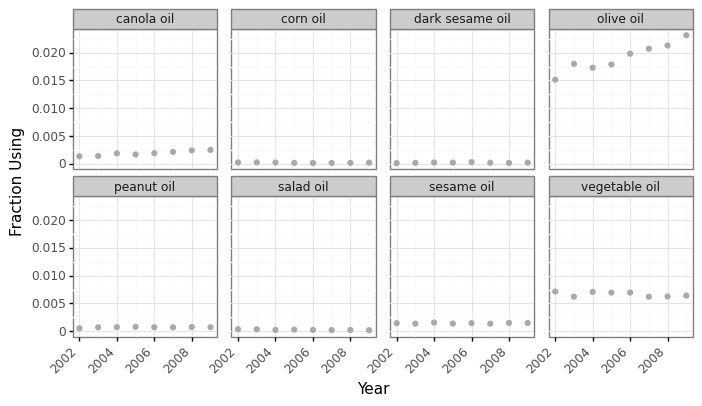

<ggplot: (8793369086205)>

In [23]:
plot_data = by_year_df[by_year_df["ingr_name"].isin(cooking_oil_names_of_interest)]

plotnine.options.dpi = 100
plotnine.options.figure_size=(8,4)
(ggplot(plot_data)
 + geom_point(aes(x="year", y="fraction_using"), color="darkgray", show_legend=False)
 + facet_wrap("ingr_name", ncol=4, scales="fixed")
 + theme_bw()
 + theme(subplots_adjust={'wspace': 0.1})
 + ylab("Fraction Using")
 + xlab("Year")
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

Looks like the fraction of recipes that use many of these types of oils are relatively consisent across this time period, with the exception of olive oil, which looks to be increasing during this time. Could this be because more recipes are using olive oil that were previously using other kinds of oil? Another way to get a clearer look at this question would be to plot the fractions of recipes using any kind of ingredient containing the word oil that use each type, so we can see how the proportions are changing over time.

In [24]:
# Subset the dataset again to include oils, this time including all of them but replacing them with 'other' if they aren't in our list of commonly used ones.
by_year_df_subsets = by_year_df.iloc[list(by_year_df["ingr_name"].apply(lambda x: ("oil" in x.split())))]
by_year_df_subsets["ingr_name"] = by_year_df_subsets["ingr_name"].map(lambda x: {name:name for name in cooking_oil_names}.get(x, "other"))
cooking_oil_names.append("other")
by_year_df_subsets.head(10)

,ingr_name,ingr_id,year,num_recipes,fraction_using
9,olive oil,5006,2002,2227,0.015134
20,vegetable oil,7557,2002,1052,0.007149
31,oil,4987,2002,843,0.005729
126,sesame oil,6413,2002,213,0.001448
138,canola oil,1043,2002,199,0.001352
169,cooking oil,1783,2002,149,0.001013
284,peanut oil,5276,2002,78,0.000530
396,salad oil,6254,2002,53,0.000360
497,corn oil,1819,2002,37,0.000251
778,dark sesame oil,2076,2002,20,0.000136


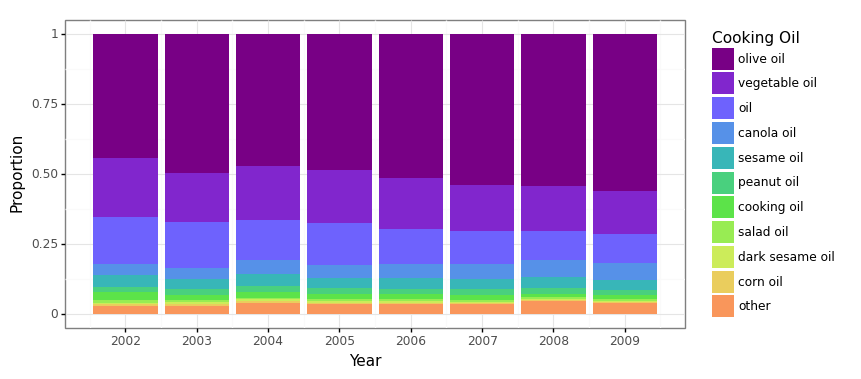

<ggplot: (8793380699001)>

In [25]:
# This is necessary to make sure the order of the sections in a given bar is the way we want it and consistent with the legend.
category_order = cooking_oil_names
by_year_df_subsets['ingr_name'] = pd.Categorical(by_year_df_subsets['ingr_name'], categories=category_order, ordered=True)

# Get a color palette and create a mapping between each ingredient that needs to be in the plot and a color palette.
from palettable.mycarta import Cube1_11
pal = Cube1_11.hex_colors
color_mapping = dict(zip(cooking_oil_names, pal[:len(cooking_oil_names)]))

# Make the plot.
(ggplot(data=by_year_df_subsets)
    + aes(y='fraction_using', x='year', fill="ingr_name")
    + scale_x_continuous(breaks=np.arange(2002,2010))
    + theme_bw()
    + geom_bar(position="fill", stat="identity")
    + ylab("Proportion")
    + xlab("Year")
    + scale_fill_manual(name="Cooking Oil", values=color_mapping, limits=cooking_oil_names)
)

## Ingredient Prediction with a Naive Bayes Model <a name="3"></a>

The names of recipes in the dataset, although messy, have relationships with the ingredients that are likely to be in the recipe. These relationships might be explicitly indicated by the name, such as 'apple pie' containing apples, or less directly, such as 'apple pie' containing flour. We can use a Naive Bayes model to predict the probabilty that a recipe includes a given ingredient given the words that are present in the recipe's name.

### Tokenizing the recipe names <a name="3.1"></a>

Let's look at the names that were provided for the recipes.

In [26]:
recipes_exploded_wrt_name_tokens = recipes.copy(deep=True)
recipes_exploded_wrt_name_tokens["name_tokens"] = recipes_exploded_wrt_name_tokens["name"].map(lambda x: x.split())
recipes_exploded_wrt_name_tokens = recipes_exploded_wrt_name_tokens.explode(column="name_tokens", ignore_index=True)
recipes_exploded_wrt_name_tokens = recipes_exploded_wrt_name_tokens[["recipe_id", "name_tokens", "ingredient_ids"]]
recipes_exploded_wrt_name_tokens.head(10)

,recipe_id,name_tokens,ingredient_ids
0,931,barbecued,"[1306, 7557, 840, 6426, 3184, 5940, 6007, 1297..."
1,931,chicken,"[1306, 7557, 840, 6426, 3184, 5940, 6007, 1297..."
2,931,thighs,"[1306, 7557, 840, 6426, 3184, 5940, 6007, 1297..."
3,931,au,"[1306, 7557, 840, 6426, 3184, 5940, 6007, 1297..."
4,931,vin,"[1306, 7557, 840, 6426, 3184, 5940, 6007, 1297..."
5,346,potatoes,"[6255, 4623, 3203, 5185, 6270]"
6,346,tapas,"[6255, 4623, 3203, 5185, 6270]"
7,346,in,"[6255, 4623, 3203, 5185, 6270]"
8,346,garlic,"[6255, 4623, 3203, 5185, 6270]"
9,346,mayonnaise,"[6255, 4623, 3203, 5185, 6270]"


Each row now refers to a specific name token in a specific recipe, with its list of ingredients. Let's explode with respect to the ingredient IDs again.

In [27]:
recipes_exploded_wrt_name_tokens["ingredient_ids"] = recipes_exploded_wrt_name_tokens['ingredient_ids'].apply(lambda x : ast.literal_eval(x))
recipes_exploded_wrt_name_tokens = recipes_exploded_wrt_name_tokens.explode(column="ingredient_ids", ignore_index=True)
recipes_exploded_wrt_name_tokens.head(10)

,recipe_id,name_tokens,ingredient_ids
0,931,barbecued,1306
1,931,barbecued,7557
2,931,barbecued,840
3,931,barbecued,6426
4,931,barbecued,3184
5,931,barbecued,5940
6,931,barbecued,6007
7,931,barbecued,1297
8,931,barbecued,5068
9,931,barbecued,2430


### Estimating the probabilities <a name="3.2"></a>
Now that we have this dataframe, we can easily extract the counts of ingredient tokens being in recipes with specific name tokens.

In [28]:
ingredient_id_to_prob = dict(zip(ingr_df["ingr_id"].values, ingr_df["frequency"]))

In [29]:
name_token_and_ingredient_id_to_counts = dict(recipes_exploded_wrt_name_tokens.groupby("name_tokens")["ingredient_ids"].value_counts())
name_token_to_count = dict(recipes_exploded_wrt_name_tokens.groupby("name_tokens").size())

In [30]:
name_token_and_ingredient_id_to_prob = lambda name_token,ingr_id: (name_token_and_ingredient_id_to_counts.get((name_token,ingr_id), 0)+1)/name_token_to_count[name_token]
name_token_and_ingredient_id_to_prob("beef", 1685)

0.000601229179656186

Let's create another labmda that lets us pass in an ingrediet ID and list of name tokens and get back to probability for that ingredient given those name tokens.

In [31]:
ingr_prob = lambda ingr_id,name_tokens: math.log(ingredient_id_to_prob[ingr_id]) + np.sum([math.log(name_token_and_ingredient_id_to_prob(name_token,ingr_id)) for name_token in name_tokens])
ingr_prob(2200, ["beef", "chicken", "soy", "rice"])

-29.05776587756862

Let's create another lambda that lets us pass in a list of tokens and get back a mapping between ingredient IDs and scores obtained using the model.

In [32]:
ingr_probs = lambda name_tokens: {ingr_id:ingr_prob(ingr_id,name_tokens) for ingr_id in ingr_df["ingr_id"].values}
#ingr_probs(["beef", "chicken", "soy", "rice"])

### Trying out the model <a name="3.3"></a>
Let's compose some potential recipe names out of individual tokens, and pass them to the model to see what the most likely ingredients for that name are.

In [33]:
recipe_name_tokens = ["stir", "fry"]
results = pd.DataFrame(zip(*ingr_probs(recipe_name_tokens).items())).transpose()
results.columns = ["ingr_id", "score"]
results = ingr_df.merge(results, on="ingr_id")
results = results.sort_values(by="score", ascending=False, ignore_index=True)
results.head(20)

,ingr_id,ingr_name,num_recipes,frequency,mean_rating,num_ratings,score
0,6696,soy sauce,9124.0,0.051182,4.432470,54531,-8.719634
1,3203,garlic clove,27349.0,0.153418,4.464374,134790,-8.752165
2,5010,onion,39143.0,0.219578,4.413349,206455,-8.910228
3,6270,salt,66483.0,0.372945,4.409567,394070,-9.112186
4,6335,scallion,13390.0,0.075113,4.510967,66288,-9.703834
5,7655,water,25953.0,0.145587,4.368039,146191,-9.733709
6,6906,sugar,33884.0,0.190077,4.395616,195993,-10.029974
7,1833,cornstarch,5601.0,0.031420,4.363260,33571,-10.158122
8,3184,garlic,14312.0,0.080285,4.455119,87186,-10.328243
9,5006,olive oil,31834.0,0.178577,4.493375,152521,-10.450842


In [34]:
recipe_name_tokens = ["beef", "burrito"]
results = pd.DataFrame(zip(*ingr_probs(recipe_name_tokens).items())).transpose()
results.columns = ["ingr_id", "score"]
results = ingr_df.merge(results, on="ingr_id")
results = results.sort_values(by="score", ascending=False, ignore_index=True)
results.head(20)

,ingr_id,ingr_name,num_recipes,frequency,mean_rating,num_ratings,score
0,5010,onion,39143.0,0.219578,4.413349,206455,-7.713616
1,6270,salt,66483.0,0.372945,4.409567,394070,-8.333464
2,3203,garlic clove,27349.0,0.153418,4.464374,134790,-9.320901
3,7655,water,25953.0,0.145587,4.368039,146191,-9.725346
4,5006,olive oil,31834.0,0.178577,4.493375,152521,-10.336757
5,1168,cheddar,12300.0,0.068998,4.434023,72851,-10.524394
6,5319,pepper,18522.0,0.103901,4.426960,98871,-10.914174
7,2499,egg,39064.0,0.219134,4.386073,228475,-10.955968
8,840,butter,43970.0,0.246655,4.428311,262718,-10.973253
9,6654,sour cream,10398.0,0.058329,4.473421,55853,-11.094590


In [35]:
recipe_name_tokens = ["apple", "pie"]
results = pd.DataFrame(zip(*ingr_probs(recipe_name_tokens).items())).transpose()
results.columns = ["ingr_id", "score"]
results = ingr_df.merge(results, on="ingr_id")
results = results.sort_values(by="score", ascending=False, ignore_index=True)
results.head(20)

,ingr_id,ingr_name,num_recipes,frequency,mean_rating,num_ratings,score
0,6270,salt,66483.0,0.372945,4.409567,394070,-7.355635
1,840,butter,43970.0,0.246655,4.428311,262718,-7.636902
2,2499,egg,39064.0,0.219134,4.386073,228475,-7.923046
3,6906,sugar,33884.0,0.190077,4.395616,195993,-8.057170
4,2683,flmy,20771.0,0.116518,4.359320,135531,-9.508215
5,4717,milk,22063.0,0.123765,4.365122,127415,-9.854741
6,1511,cinnamon,9958.0,0.055861,4.399003,56363,-10.225778
7,800,brown sugar,15217.0,0.085362,4.427005,95055,-10.262059
8,5010,onion,39143.0,0.219578,4.413349,206455,-10.433483
9,7655,water,25953.0,0.145587,4.368039,146191,-10.487716
